In [162]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, make_scorer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb


In [2]:
#!pip install xgboost
#!pip install catboost
#!pip install lightgbm

In [244]:
train = pd.read_csv('course_project_train.csv')
test = pd.read_csv('course_project_test.csv')

In [245]:
train.head()

Home Ownership  Annual Income Years in current job  Tax Liens  \
0       Own Home       482087.0                  NaN        0.0   
1       Own Home      1025487.0            10+ years        0.0   
2  Home Mortgage       751412.0              8 years        0.0   
3       Own Home       805068.0              6 years        0.0   
4           Rent       776264.0              8 years        0.0   

   Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
0                     11.0                     26.3             685960.0   
1                     15.0                     15.3            1181730.0   
2                     11.0                     35.0            1182434.0   
3                      8.0                     22.5             147400.0   
4                     13.0                     13.6             385836.0   

   Number of Credit Problems  Months since last delinquent  Bankruptcies  \
0                        1.0                           NaN           1.0   
1                        0.0                           NaN           0.0   
2                        0.0                           NaN           0.0   
3                        1.0                           NaN           1.0   
4                        1.0                           NaN           0.0   

              Purpose        Term  Current Loan Amount  \
0  debt consolidation  Short Term           99999999.0   
1  debt consolidation   Long Term             264968.0   
2  debt consolidation  Short Term           99999999.0   
3  debt consolidation  Short Term             121396.0   
4  debt consolidation  Short Term             125840.0   

   Current Credit Balance  Monthly Debt  Credit Score  Credit Default  
0                 47386.0        7914.0         749.0               0  
1                394972.0       18373.0         737.0               1  
2                308389.0       13651.0         742.0               0  
3                 95855.0       11338.0         694.0               0  
4                 93309.0        7180.0         719.0               0

In [246]:
#функция построения гистограммы
def draw_hist(data,column):
    fig = px.histogram(data,nbins = 100)
    fig.update_layout(
    title= column + ' hist',
    xaxis_title=column,
    yaxis_title="Count")
    fig.show()
    
#функция очистки от выбросов с помощью межквантильного диапазона     
def iqr_check(data,column):
    IQR = data[column].describe()['75%'] - data[column].describe()['25%']
    min_limit = data[column].describe()['25%'] - IQR*1.5
    max_limit = data[column].describe()['75%'] + IQR*1.5
    #print('IQR',IQR,'Min',min_limit,'Max',max_limit,'Len',len(data[(data[column]<min_limit)|(data[column]>max_limit)]))
    data = data[(data[column]>min_limit)&(data[column]<max_limit)]
    return data

def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))
    
def credit_score_down(df):
    df.loc[df['Credit Score']>800,'Credit Score'] =  df.loc[df['Credit Score']>800,'Credit Score']/10
    return df

def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()
    
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

1. Обзор обучающего датасета

In [247]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

**Описание датасета**

* **Home Ownership** - форма домовладения
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - кредитный рейтинг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

2. Обработка выбросов

Изучим распределение числовых переменных на предмет выбросов 

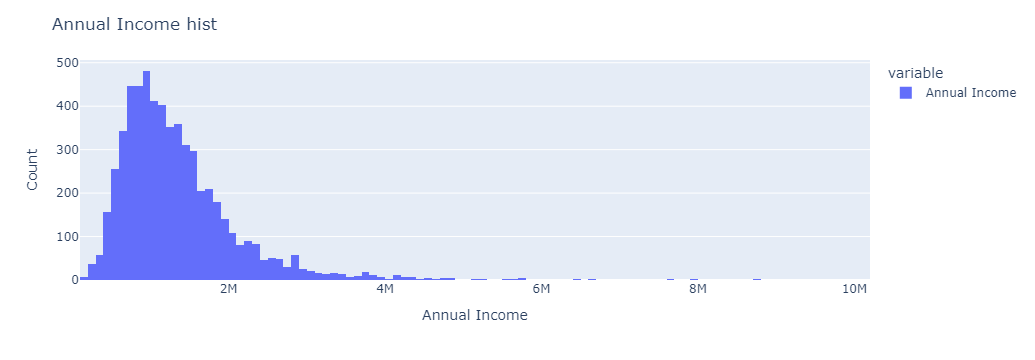

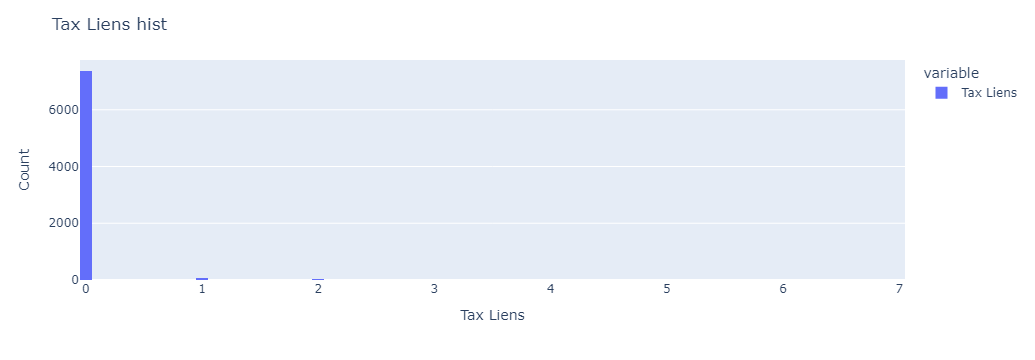

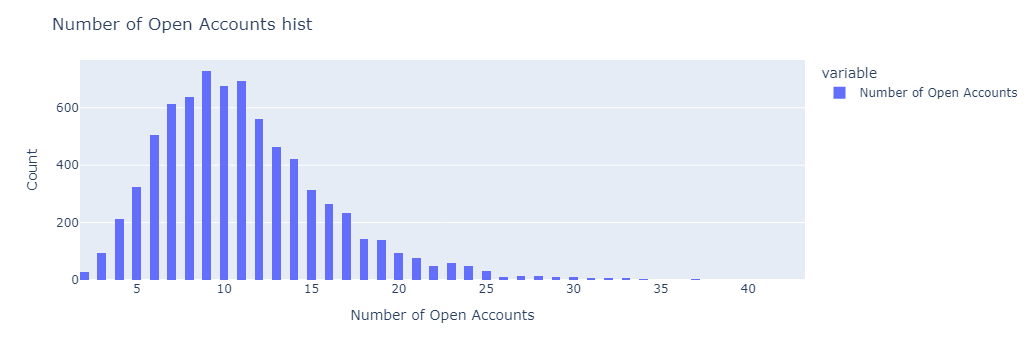

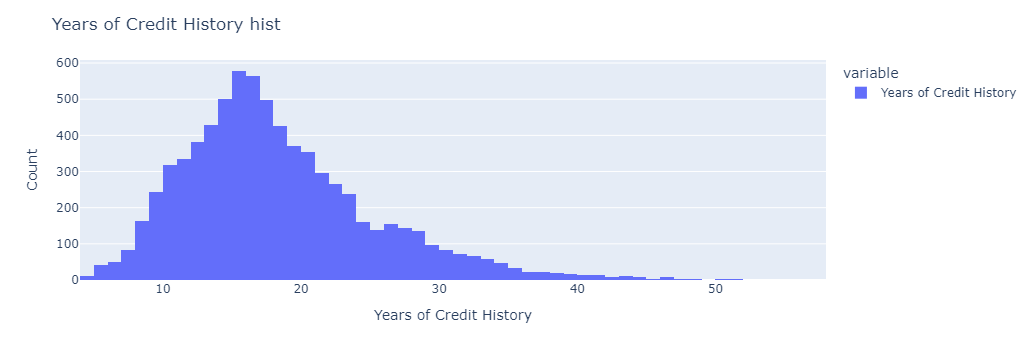

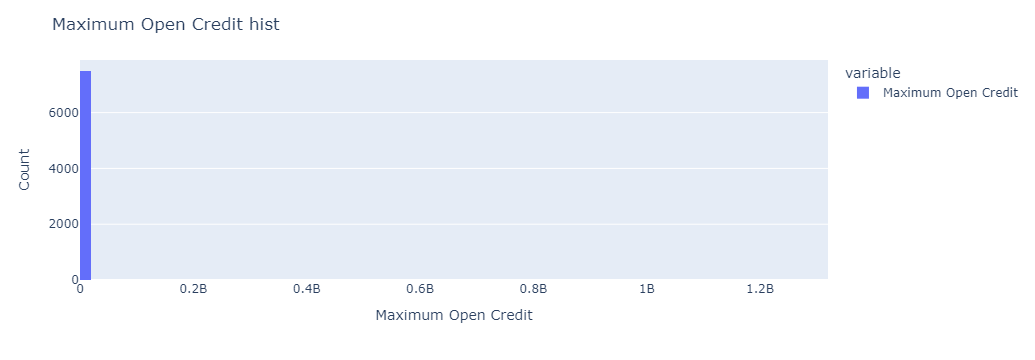

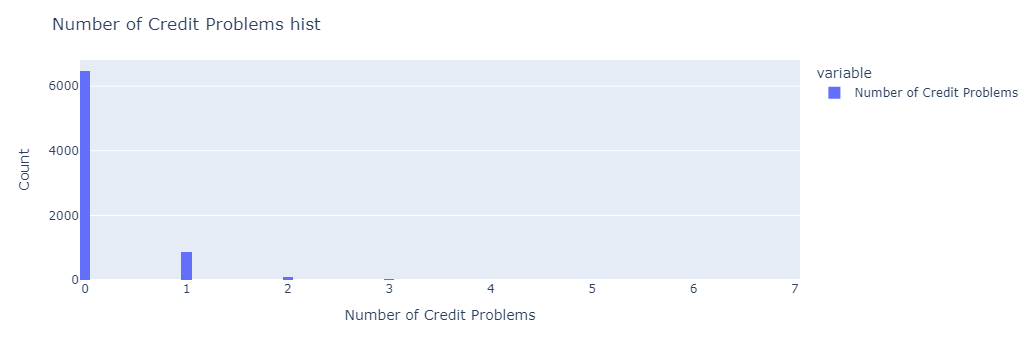

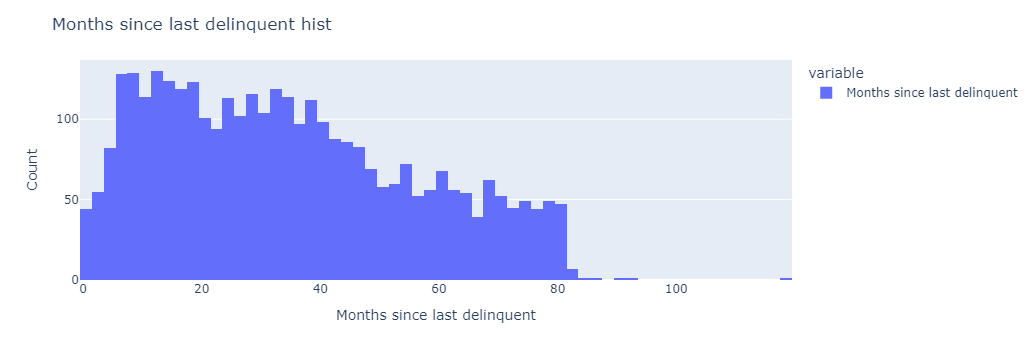

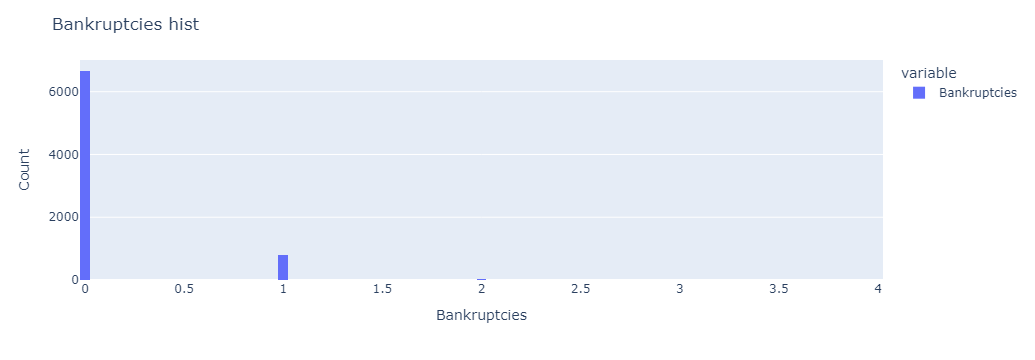

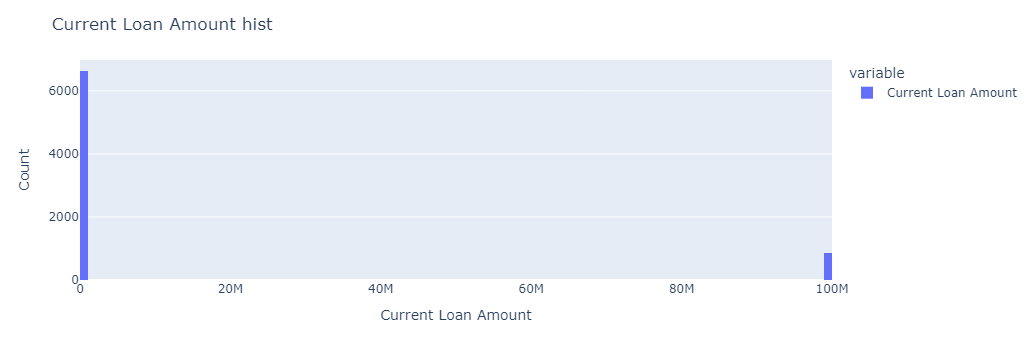

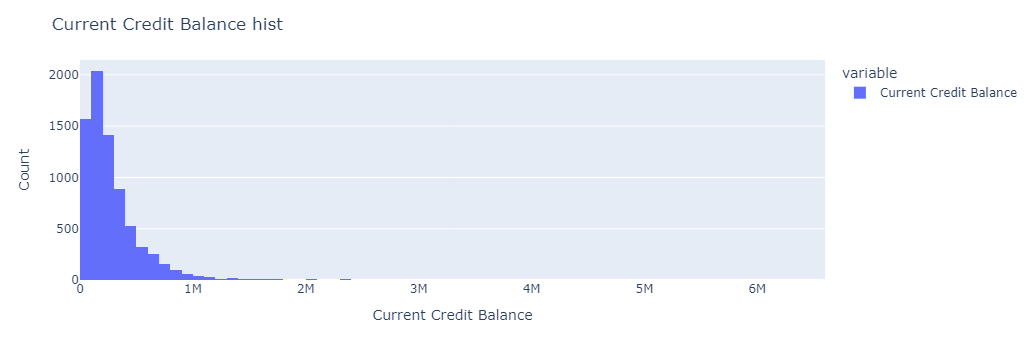

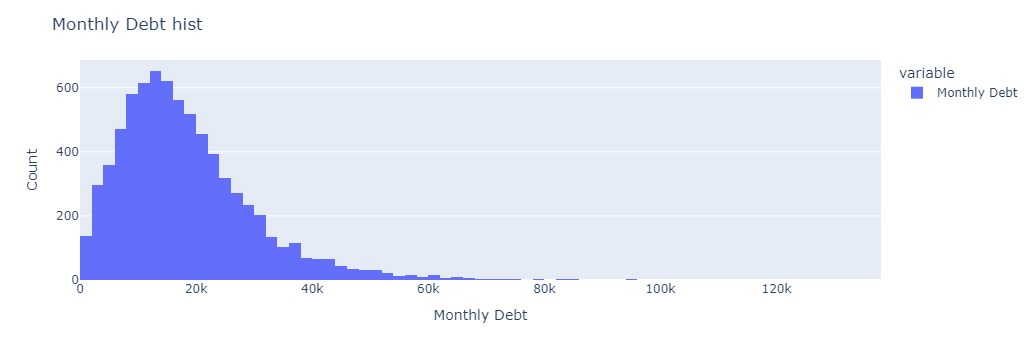

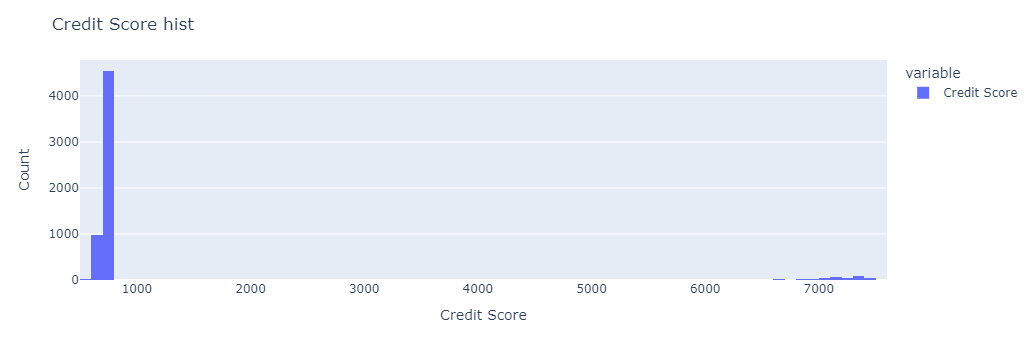

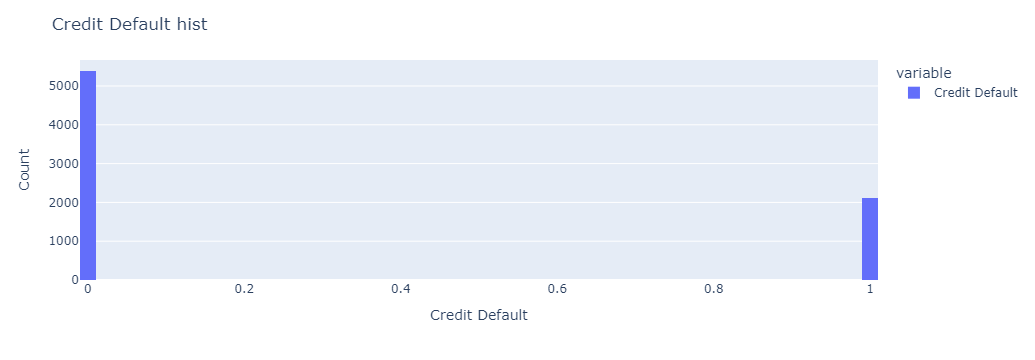

In [248]:
for i in train.select_dtypes(include='number').columns.tolist():
    draw_hist(train[i],i)

Часть распределений столбцов смещена влево из-за небольшого количества относительно больших значений. Выполним проверку на выбросы с помощью межквантильного диапазона. Записи определенные как выбросы удалим из тренировочной выборки. Проверку будем выполнять для числовых столбцов за исключением категориальных (Tax Liens,Number of Credit Problems,Bankruptcies)

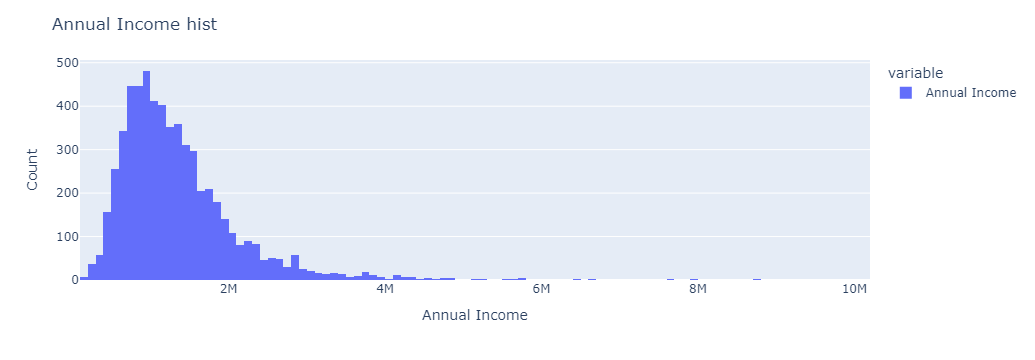

IQR 795796.0 Mix -349353.0 Max 2833831.0 Len 287


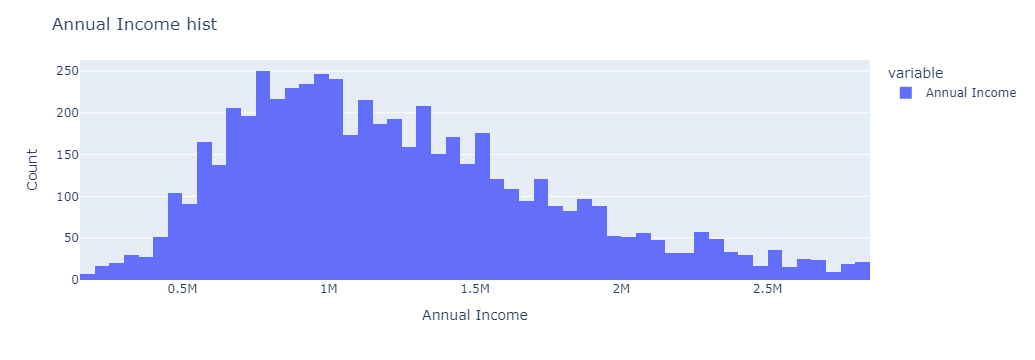

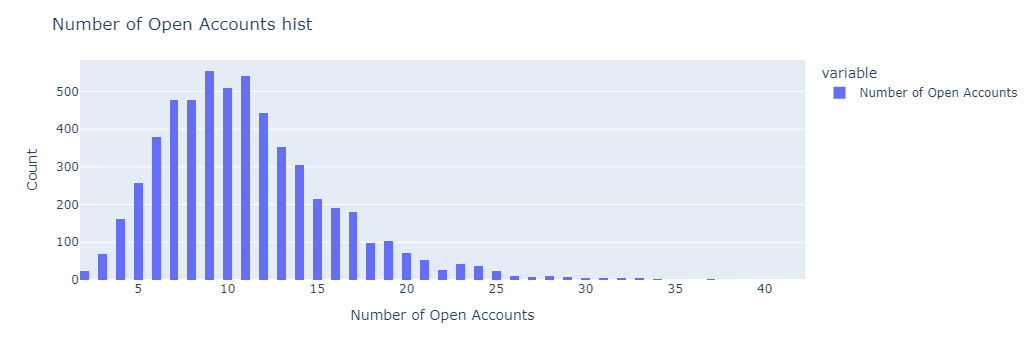

IQR 5.0 Mix 0.5 Max 20.5 Len 247


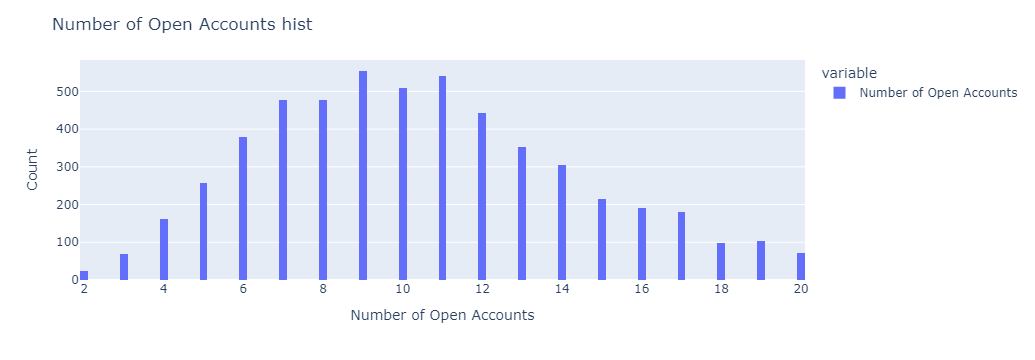

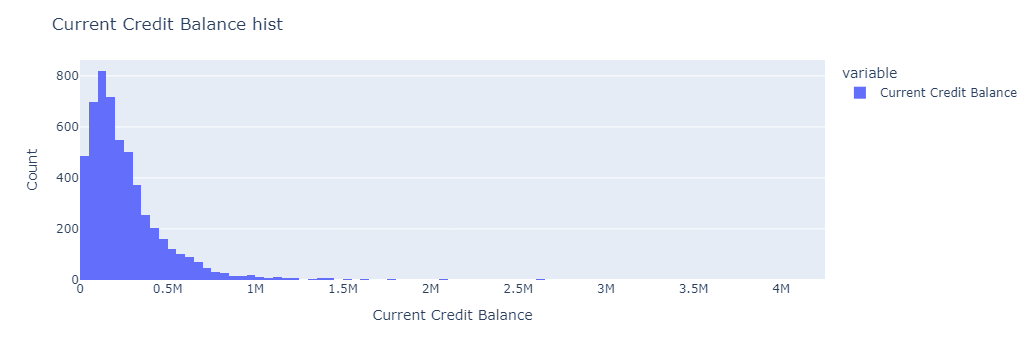

IQR 226556.0 Mix -229748.0 Max 676476.0 Len 281


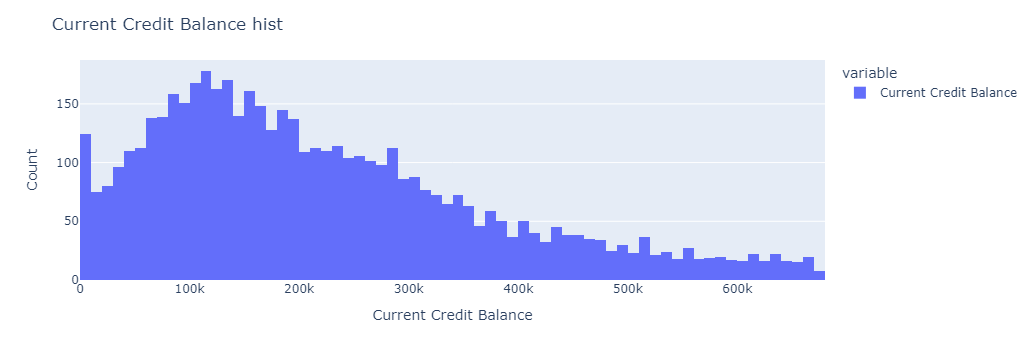

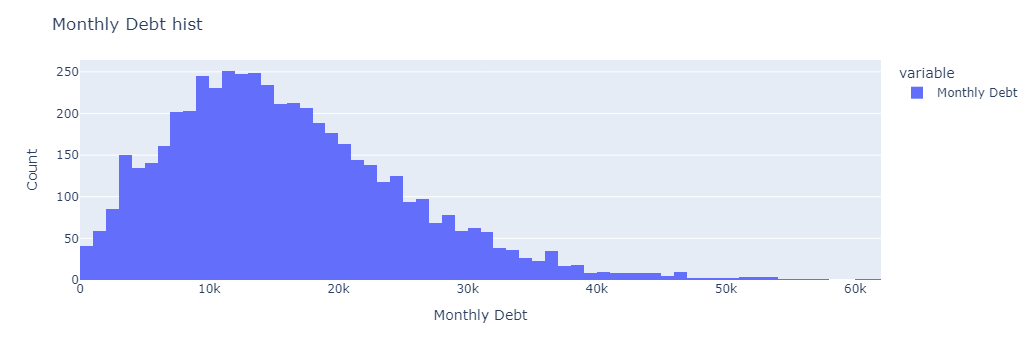

IQR 11892.0 Mix -8375.75 Max 39192.25 Len 96


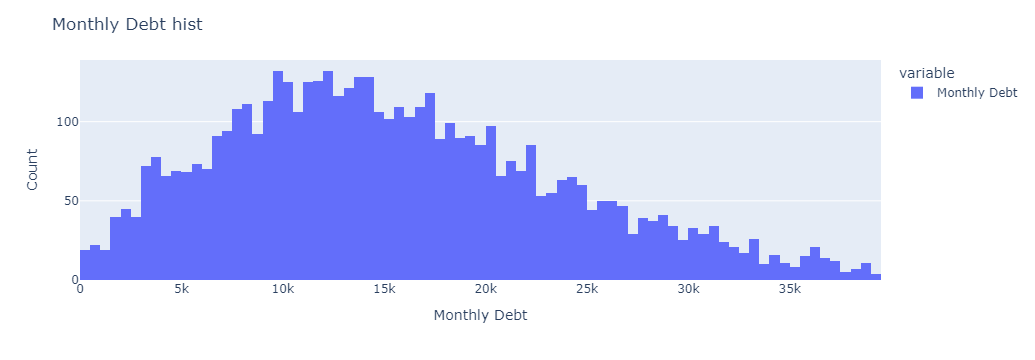

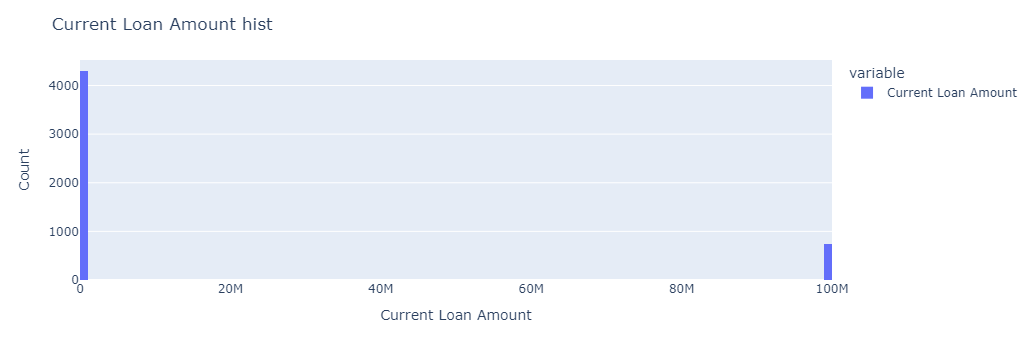

IQR 332442.0 Mix -320798.5 Max 1008969.5 Len 734


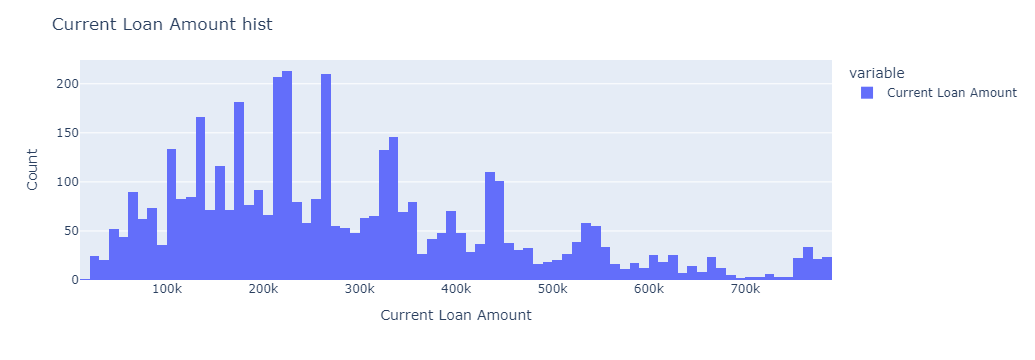

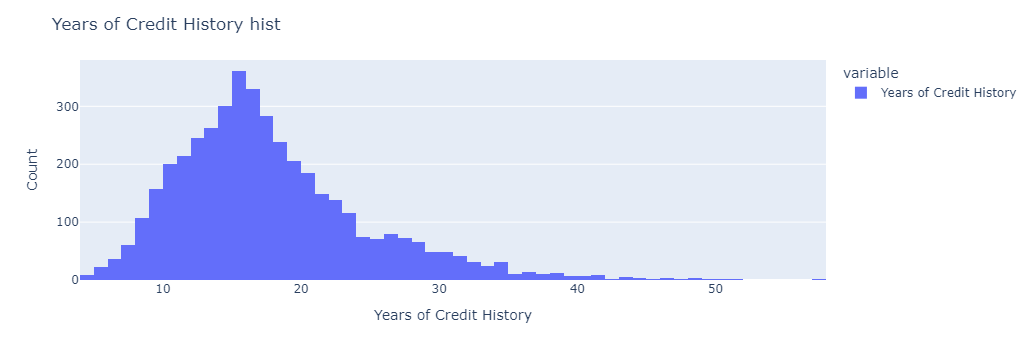

IQR 8.0 Mix 1.0 Max 33.0 Len 144


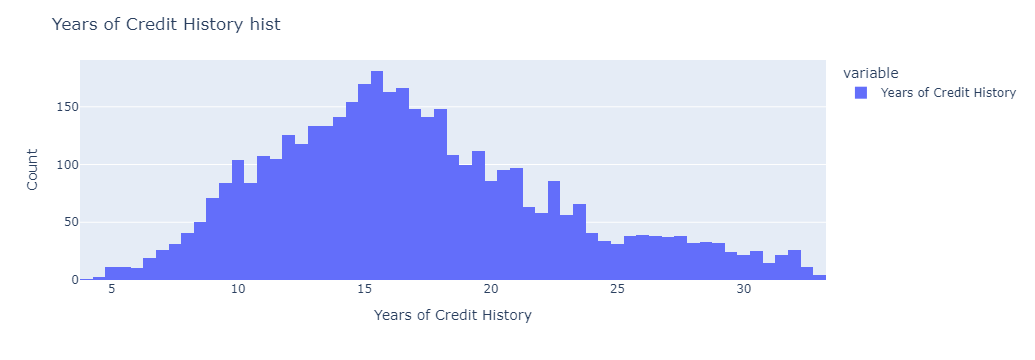

In [249]:
for i in ['Annual Income','Number of Open Accounts','Current Credit Balance','Monthly Debt','Current Loan Amount','Years of Credit History']:
    draw_hist(train[i],i)
    train = iqr_check(train,i) 
    draw_hist(train[i],i)

3. Обработка пропусков

In [250]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4149 entries, 1 to 7496
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                4149 non-null   object 
 1   Annual Income                 4149 non-null   float64
 2   Years in current job          3955 non-null   object 
 3   Tax Liens                     4149 non-null   float64
 4   Number of Open Accounts       4149 non-null   float64
 5   Years of Credit History       4149 non-null   float64
 6   Maximum Open Credit           4149 non-null   float64
 7   Number of Credit Problems     4149 non-null   float64
 8   Months since last delinquent  1940 non-null   float64
 9   Bankruptcies                  4140 non-null   float64
 10  Purpose                       4149 non-null   object 
 11  Term                          4149 non-null   object 
 12  Current Loan Amount           4149 non-null   float64
 13  Cur

In [251]:
nan_columns = ['Years in current job','Months since last delinquent','Bankruptcies']
for i in nan_columns:
    train.loc[train[i].isna() == True, i] = train[i].mode()[0]

In [252]:
train.loc[train['Annual Income'].isna() == True, 'Annual Income'] = train['Annual Income'].median()
train.loc[train['Credit Score'].isna() == True, 'Credit Score'] = train['Credit Score'].median()

In [253]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4149 entries, 1 to 7496
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                4149 non-null   object 
 1   Annual Income                 4149 non-null   float64
 2   Years in current job          4149 non-null   object 
 3   Tax Liens                     4149 non-null   float64
 4   Number of Open Accounts       4149 non-null   float64
 5   Years of Credit History       4149 non-null   float64
 6   Maximum Open Credit           4149 non-null   float64
 7   Number of Credit Problems     4149 non-null   float64
 8   Months since last delinquent  4149 non-null   float64
 9   Bankruptcies                  4149 non-null   float64
 10  Purpose                       4149 non-null   object 
 11  Term                          4149 non-null   object 
 12  Current Loan Amount           4149 non-null   float64
 13  Cur

4. Анализ данных

In [254]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = train.columns.drop(TARGET_NAME).tolist()
train[TARGET_NAME].value_counts()

0    2832
1    1317
Name: Credit Default, dtype: int64

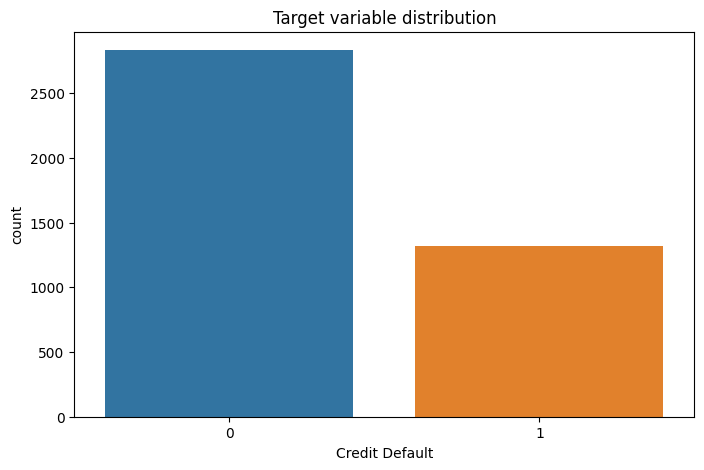

In [255]:
plt.figure(figsize=(8, 5))

sns.countplot(x=TARGET_NAME, data=train)

plt.title('Target variable distribution')
plt.show()

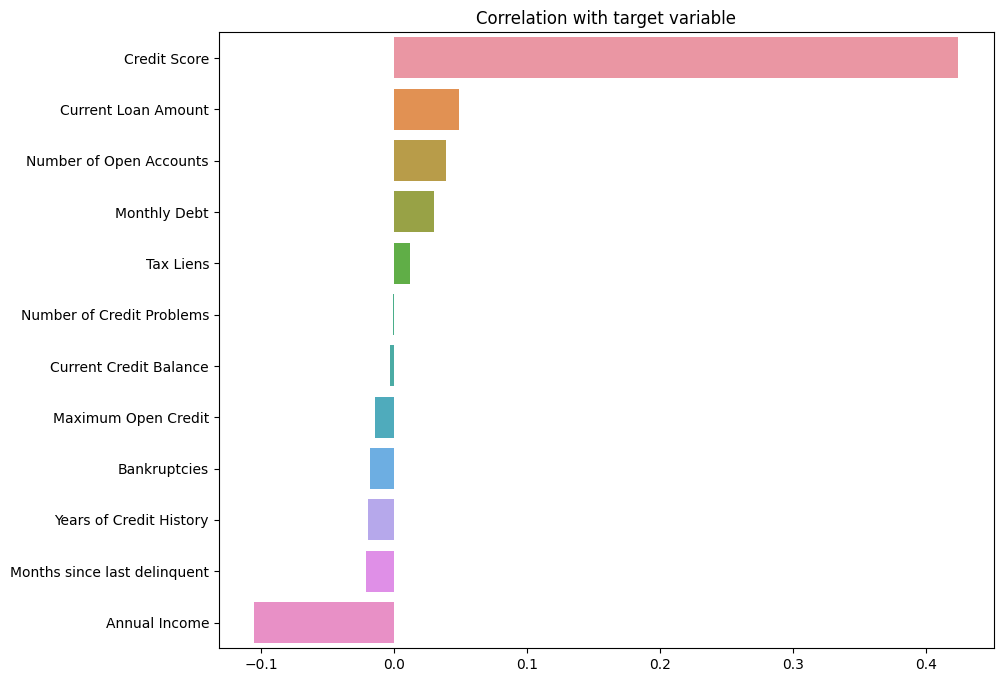

In [256]:
corr_with_target = train[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

Как мы видим, наибольшее влияние оказывает признак Credit Score. Выполним анализ

In [257]:
train['Credit Score'].describe()

count    4149.000000
mean     1219.366594
std      1719.944546
min       585.000000
25%       709.000000
50%       730.000000
75%       742.000000
max      7510.000000
Name: Credit Score, dtype: float64

Добавим признак Credit Score Category, разделив всех на 5 категорий

In [258]:
# Определение меток для категорий
category_labels = [1, 2, 3, 4, 5]

# Разделение значений на 5 категорий с метками
train['Credit Score Category'] = pd.cut(train['Credit Score'], bins=5, labels=category_labels)

In [259]:
#Преобразуем категориальные переменные с помощью get_dummies
df_dummies = pd.get_dummies(train)

In [260]:
train

Home Ownership  Annual Income Years in current job  Tax Liens  \
1          Own Home      1025487.0            10+ years        0.0   
3          Own Home       805068.0              6 years        0.0   
4              Rent       776264.0              8 years        0.0   
7              Rent      1040060.0            10+ years        0.0   
11    Home Mortgage      1828560.0              4 years        0.0   
...             ...            ...                  ...        ...   
7489  Home Mortgage      1394942.0            10+ years        0.0   
7490       Own Home      1368000.0            10+ years        0.0   
7493           Rent      1257610.0              8 years        0.0   
7495           Rent       402192.0             < 1 year        0.0   
7496  Home Mortgage      1533984.0               1 year        0.0   

      Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
1                        15.0                     15.3            1181730.0   
3                         8.0                     22.5             147400.0   
4                        13.0                     13.6             385836.0   
7                        13.0                     12.0             330374.0   
11                       12.0                     17.6             839080.0   
...                       ...                      ...                  ...   
7489                     15.0                     27.2            1441396.0   
7490                     20.0                     26.7             897842.0   
7493                     14.0                     16.5             821480.0   
7495                      3.0                      8.5             107866.0   
7496                     10.0                     26.5             686312.0   

      Number of Credit Problems  Months since last delinquent  Bankruptcies  \
1                           0.0                          38.0           0.0   
3                           1.0                          38.0           1.0   
4                           1.0                          38.0           0.0   
7                           0.0                          18.0           0.0   
11                          0.0                          38.0           0.0   
...                         ...                           ...           ...   
7489                        0.0                          35.0           0.0   
7490                        0.0                          69.0           0.0   
7493                        0.0                          58.0           0.0   
7495                        0.0                          38.0           0.0   
7496                        0.0                          43.0           0.0   

                 Purpose        Term  Current Loan Amount  \
1     debt consolidation   Long Term             264968.0   
3     debt consolidation  Short Term             121396.0   
4     debt consolidation  Short Term             125840.0   
7                  other  Short Term             250888.0   
11    debt consolidation  Short Term             441100.0   
...                  ...         ...                  ...   
7489  debt consolidation  Short Term             753764.0   
7490  debt consolidation  Short Term             683650.0   
7493  debt consolidation   Long Term             448052.0   
7495               other  Short Term             129360.0   
7496  debt consolidation   Long Term             444048.0   

      Current Credit Balance  Monthly Debt  Credit Score  Credit Default  \
1                   394972.0       18373.0         737.0               1   
3                    95855.0       11338.0         694.0               0   
4                    93309.0        7180.0         719.0               0   
7                    89015.0       19761.0         705.0               1   
11                  402914.0       15528.0         737.0               0   
...                      ...           ...           ...             ...   
7

In [261]:
df_dummies

Annual Income  Tax Liens  Number of Open Accounts  \
1         1025487.0        0.0                     15.0   
3          805068.0        0.0                      8.0   
4          776264.0        0.0                     13.0   
7         1040060.0        0.0                     13.0   
11        1828560.0        0.0                     12.0   
...             ...        ...                      ...   
7489      1394942.0        0.0                     15.0   
7490      1368000.0        0.0                     20.0   
7493      1257610.0        0.0                     14.0   
7495       402192.0        0.0                      3.0   
7496      1533984.0        0.0                     10.0   

      Years of Credit History  Maximum Open Credit  Number of Credit Problems  \
1                        15.3            1181730.0                        0.0   
3                        22.5             147400.0                        1.0   
4                        13.6             385836.0                        1.0   
7                        12.0             330374.0                        0.0   
11                       17.6             839080.0                        0.0   
...                       ...                  ...                        ...   
7489                     27.2            1441396.0                        0.0   
7490                     26.7             897842.0                        0.0   
7493                     16.5             821480.0                        0.0   
7495                      8.5             107866.0                        0.0   
7496                     26.5             686312.0                        0.0   

      Months since last delinquent  Bankruptcies  Current Loan Amount  \
1                             38.0           0.0             264968.0   
3                             38.0           1.0             121396.0   
4                             38.0           0.0             125840.0   
7                             18.0           0.0             250888.0   
11                            38.0           0.0             441100.0   
...                            ...           ...                  ...   
7489                          35.0           0.0             753764.0   
7490                          69.0           0.0             683650.0   
7493                          58.0           0.0             448052.0   
7495                          38.0           0.0             129360.0   
7496                          43.0           0.0             444048.0   

      Current Credit Balance  ...  Purpose_take a trip  Purpose_vacation  \
1                   394972.0  ...                    0                 0   
3                    95855.0  ...                    0                 0   
4                    93309.0  ...                    0                 0   
7                    89015.0  ...                    0                 0   
11                  402914.0  ...                    0                 0   
...                      ...  ...                  ...               ...   
7489                496698.0  ...                    0                 0   
7490                517199.0  ...                    0                 0   
7493                167428.0  ...                    0                 0   
7495                 73492.0  ...                    0                 0   
7496                456399.0  ...                    0                 0   

      Purpose_wedding  Term_Long Term  Term_Short Term  \
1                   0               1                0   
3                   0               0                1   
4                   0               0                1   
7                   0               0                1   
11                  0               0                1   
...               ...             ...              ...   
7489                0               0                1   
7490                0               0                1   
7493        

In [262]:
train = df_dummies

5. Отбор признаков

In [263]:
NUMERIC_FEATURE_NAMES = ['Annual Income','Tax Liens','Number of Open Accounts','Years of Credit History','Maximum Open Credit','Number of Credit Problems','Months since last delinquent','Bankruptcies','Current Loan Amount','Current Credit Balance','Monthly Debt','Credit Score']

Нормализация данных

In [264]:
scaler = StandardScaler()

df_norm = train.copy()
df_norm[NUMERIC_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUMERIC_FEATURE_NAMES])

train = df_norm.copy()
train.rename(columns={'Years in current job_< 1 year': 'Years in current job_less 1 year'}, inplace=True)

In [265]:
TARGET_NAME = 'Credit Default'
FEATURE_NAMES_SELECTED = train.columns.drop([TARGET_NAME])

In [266]:
X = train[FEATURE_NAMES_SELECTED]
y = train[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.25, random_state=42)

6. Балансировка классов

In [267]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

C:\Users\denis\AppData\Local\Temp\ipykernel_38116\1855569196.py:30: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



0    2134
1    1954
Name: Credit Default, dtype: int64

7. Подбор моделей

In [268]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

In [269]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.65      0.82      0.73      2134
           1       0.73      0.52      0.61      1954

    accuracy                           0.68      4088
   macro avg       0.69      0.67      0.67      4088
weighted avg       0.69      0.68      0.67      4088

TEST

              precision    recall  f1-score   support

           0       0.78      0.83      0.80       698
           1       0.59      0.51      0.55       340

    accuracy                           0.72      1038
   macro avg       0.68      0.67      0.67      1038
weighted avg       0.71      0.72      0.72      1038

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               576  122
1               166  174


C:\Users\denis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [270]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.75      0.85      0.79      2134
           1       0.81      0.69      0.74      1954

    accuracy                           0.77      4088
   macro avg       0.78      0.77      0.77      4088
weighted avg       0.78      0.77      0.77      4088

TEST

              precision    recall  f1-score   support

           0       0.73      0.74      0.74       698
           1       0.46      0.45      0.45       340

    accuracy                           0.64      1038
   macro avg       0.60      0.59      0.59      1038
weighted avg       0.64      0.64      0.64      1038

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               516  182
1               187  153


In [271]:
model_xgb = xgb.XGBClassifier(random_state=21)
model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2134
           1       1.00      1.00      1.00      1954

    accuracy                           1.00      4088
   macro avg       1.00      1.00      1.00      4088
weighted avg       1.00      1.00      1.00      4088

TEST

              precision    recall  f1-score   support

           0       0.75      0.83      0.79       698
           1       0.55      0.44      0.49       340

    accuracy                           0.70      1038
   macro avg       0.65      0.63      0.64      1038
weighted avg       0.69      0.70      0.69      1038

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               576  122
1               189  151


In [272]:
model_lgbm = lgbm.LGBMClassifier(random_state=21)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1954, number of negative: 2134
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000328 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1901
[LightGBM] [Info] Number of data points in the train set: 4088, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.477984 -> initscore=-0.088120
[LightGBM] [Info] Start training from score -0.088120
TRAIN

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2134
           1       0.99      0.97      0.98      1954

    accuracy                           0.98      4088
   macro avg       0.98      0.98      0.98      4088
weighted avg       0.98      0.98      0.98      4088

TEST

              precision  

In [273]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.91      0.98      0.94      2134
           1       0.97      0.89      0.93      1954

    accuracy                           0.94      4088
   macro avg       0.94      0.94      0.94      4088
weighted avg       0.94      0.94      0.94      4088

TEST

              precision    recall  f1-score   support

           0       0.76      0.86      0.81       698
           1       0.60      0.44      0.51       340

    accuracy                           0.72      1038
   macro avg       0.68      0.65      0.66      1038
weighted avg       0.71      0.72      0.71      1038

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               599   99
1               190  150


8. Выбор наилучшей модели, настройка гиперпараметров

Из представленных моделей лучшие результаты показа модель LogisticRegression, выполним для неё подбор гиперпараметров

In [274]:
# Определение модели
model = LogisticRegression(random_state=42, solver='liblinear', max_iter=1000)

# Задание параметров для поиска
params = {
    'penalty': ['l1', 'l2'],
    'C': np.logspace(-4, 4, 20),
    'class_weight': [None, 'balanced']
}

# Задание кросс-валидации
cv = KFold(n_splits=3, random_state=21, shuffle=True)

# Определение мульти-метрического подхода
scoring = {
    'f1': make_scorer(f1_score, average='macro'),
    'precision': make_scorer(precision_score, average='macro'),
    'recall': make_scorer(recall_score, average='macro')
}

# Настройка RandomizedSearchCV
rs = RandomizedSearchCV(model, params, scoring=scoring, refit='f1', cv=cv, n_jobs=-1, random_state=42, n_iter=50)

# Выполнение подбора гиперпараметров
rs.fit(X_train, y_train)

# Получение лучших параметров
best_params = rs.best_params_
print("Лучшие параметры:", best_params)

Лучшие параметры: {'penalty': 'l2', 'class_weight': None, 'C': 545.5594781168514}


Обучение и оценка финальной модели

In [275]:
%%time

# Проверка обучения новой модели с лучшими параметрами
final_model = LogisticRegression(**best_params, random_state=42, solver='liblinear', max_iter=1000)
final_model.fit(X_train, y_train)

# Предсказание на обучающей и тестовой выборках
y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)


get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.66      0.82      0.73      2134
           1       0.74      0.54      0.62      1954

    accuracy                           0.69      4088
   macro avg       0.70      0.68      0.68      4088
weighted avg       0.70      0.69      0.68      4088

TEST

              precision    recall  f1-score   support

           0       0.77      0.82      0.80       698
           1       0.58      0.51      0.54       340

    accuracy                           0.72      1038
   macro avg       0.68      0.66      0.67      1038
weighted avg       0.71      0.72      0.71      1038

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               571  127
1               167  173
CPU times: total: 125 ms
Wall time: 123 ms


9. Проверка качества, борьба с переобучением

In [276]:
# Проверка обучения новой модели с лучшими параметрами
final_model = LogisticRegression(**best_params, random_state=42, solver='liblinear', max_iter=1000)
final_model.fit(X_train, y_train)

# Предсказание на обучающей и тестовой выборках
y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.66      0.82      0.73      2134
           1       0.74      0.54      0.62      1954

    accuracy                           0.69      4088
   macro avg       0.70      0.68      0.68      4088
weighted avg       0.70      0.69      0.68      4088

TEST

              precision    recall  f1-score   support

           0       0.77      0.82      0.80       698
           1       0.58      0.51      0.54       340

    accuracy                           0.72      1038
   macro avg       0.68      0.66      0.67      1038
weighted avg       0.71      0.72      0.71      1038

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               571  127
1               167  173


Подбор оптимального размера выборки, кривая обучения

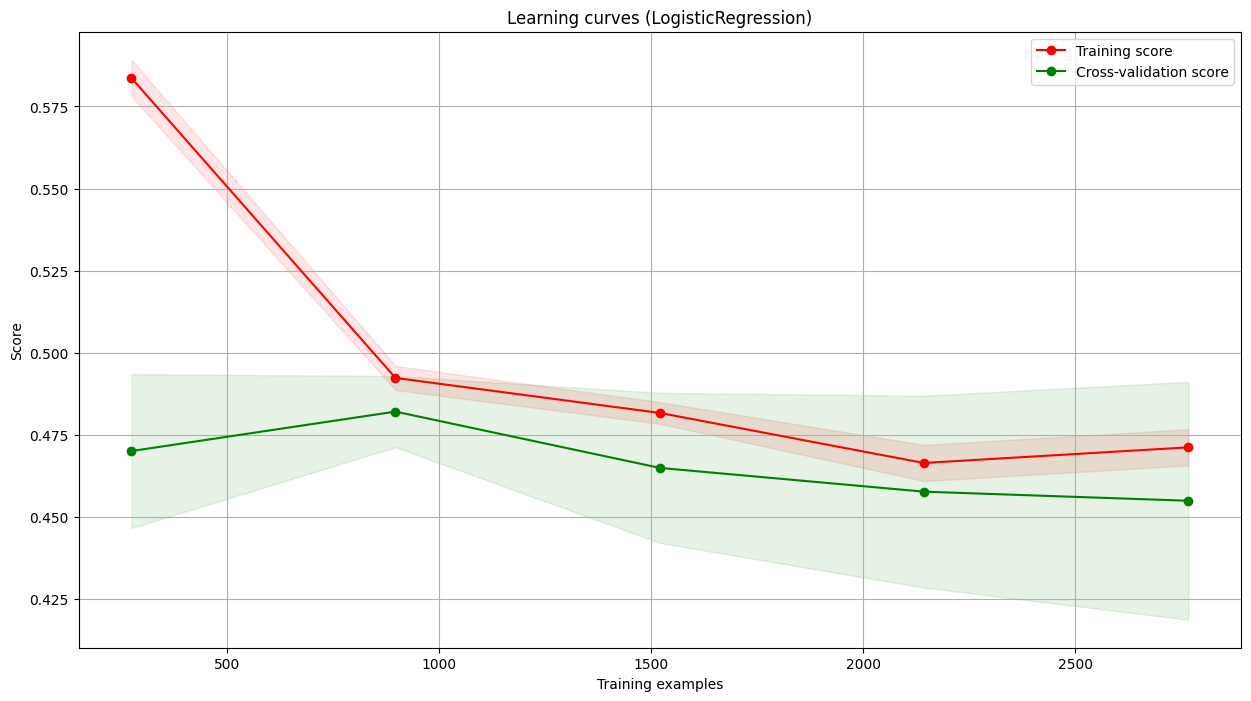

In [277]:
show_learning_curve_plot(final_model, X, y)

Выбор порога вероятности для определения класса

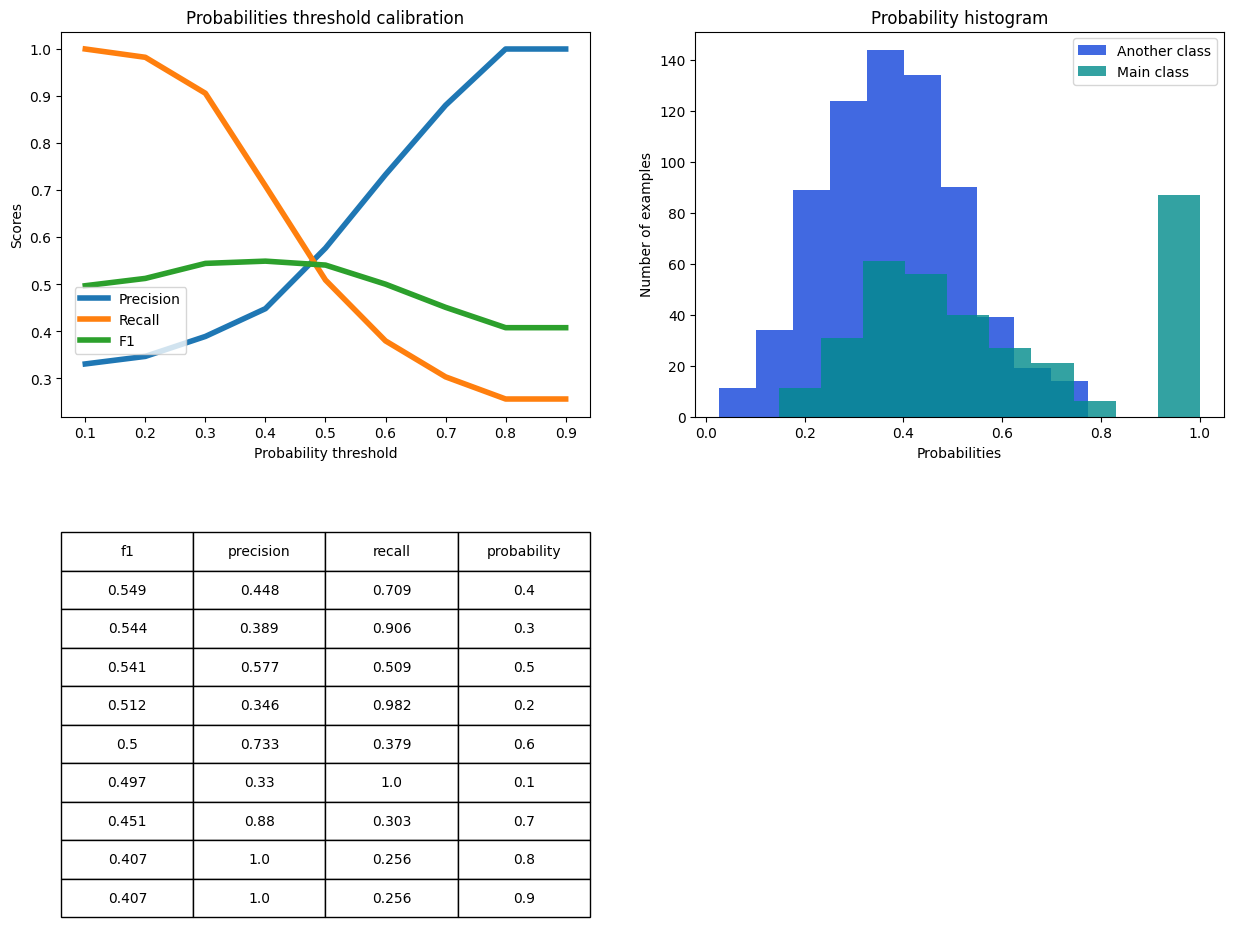

In [278]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

Важность признаков

C:\Users\denis\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



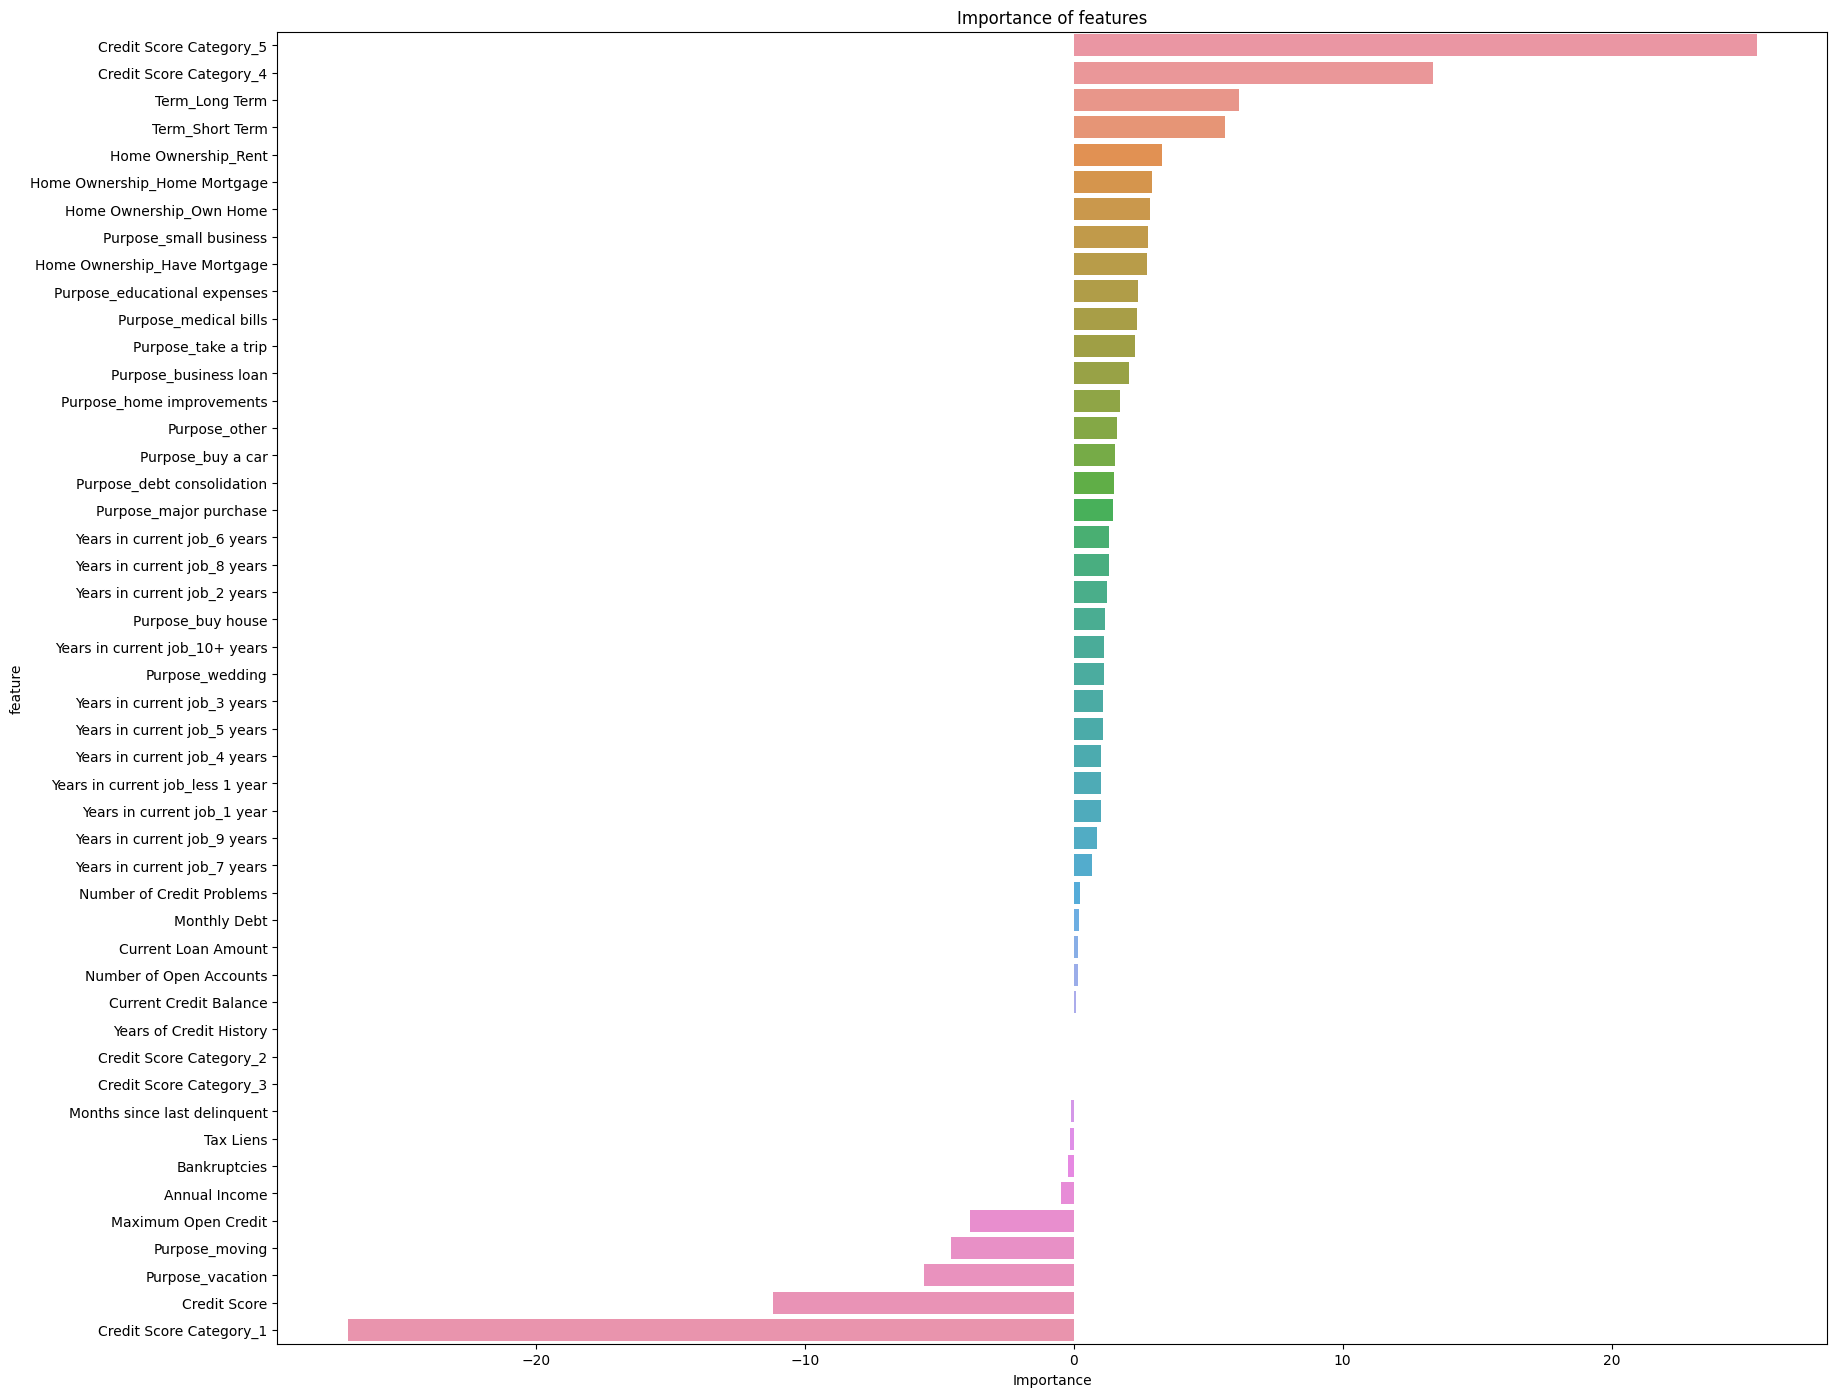

['Credit Score Category_5', 'Credit Score Category_4', 'Term_Long Term', 'Term_Short Term', 'Home Ownership_Rent', 'Home Ownership_Home Mortgage', 'Home Ownership_Own Home', 'Purpose_small business', 'Home Ownership_Have Mortgage', 'Purpose_educational expenses', 'Purpose_medical bills', 'Purpose_take a trip', 'Purpose_business loan', 'Purpose_home improvements', 'Purpose_other', 'Purpose_buy a car', 'Purpose_debt consolidation', 'Purpose_major purchase', 'Years in current job_6 years', 'Years in current job_8 years', 'Years in current job_2 years', 'Purpose_buy house', 'Years in current job_10+ years', 'Purpose_wedding', 'Years in current job_3 years', 'Years in current job_5 years', 'Years in current job_4 years', 'Years in current job_less 1 year', 'Years in current job_1 year', 'Years in current job_9 years', 'Years in current job_7 years', 'Number of Credit Problems', 'Monthly Debt', 'Current Loan Amount', 'Number of Open Accounts', 'Current Credit Balance', 'Years of Credit Histo

In [279]:
important_features_top = show_feature_importances(X_train.columns, final_model.coef_[0], get_top=48)
print(important_features_top)

На графике видно, что существуеют параметры имеющие большое положительный и отрицательное влияние, поэтому возьмём 10 параметров с бОльшим абсолютным весом, то есть 5 с начала и 5 с конца.

In [280]:
important_features_top = important_features_top[:5]+important_features_top[-5:]

Финальная модель

In [ ]:
# Проверка обучения новой модели с лучшими параметрами
final_model = LogisticRegression(**best_params, random_state=42, solver='liblinear', max_iter=1000)
final_model.fit(X_train[important_features_top], y_train)

# Предсказание на обучающей и тестовой выборках
y_train_pred = final_model.predict(X_train[important_features_top])
y_test_pred = final_model.predict(X_test[important_features_top])
y_test_pred_probs = final_model.predict_proba(X_test[important_features_top])

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.64      0.86      0.73      2134
           1       0.75      0.47      0.58      1954

    accuracy                           0.67      4088
   macro avg       0.69      0.66      0.65      4088
weighted avg       0.69      0.67      0.66      4088

TEST

              precision    recall  f1-score   support

           0       0.78      0.86      0.82       698
           1       0.64      0.51      0.56       340

    accuracy                           0.74      1038
   macro avg       0.71      0.68      0.69      1038
weighted avg       0.73      0.74      0.74      1038

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               600   98
1               168  172


Как видим, отбор наиболее важных признаков позволил увеличить precision 0.58 с до 0.64 и f1-score с 0.54 до 0.56 

Сохраним модель

In [285]:
# output
MODEL_FILE_PATH = 'model.pkl'
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(final_model, file)

**Прогнозирование на тестовом датасете**

1. Выполним для тестового датасета те же этапы обработки и построения признаков

In [288]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 2500 non-null   float64
 2   Years in current job          2500 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  2500 non-null   float64
 9   Bankruptcies                  2500 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

In [287]:
for i in nan_columns:
    test.loc[test[i].isna() == True, i] = test[i].mode()[0]
test.loc[test['Annual Income'].isna() == True, 'Annual Income'] = test['Annual Income'].median()
test.loc[test['Credit Score'].isna() == True, 'Credit Score'] = test['Credit Score'].median()

In [290]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 2500 non-null   float64
 2   Years in current job          2500 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  2500 non-null   float64
 9   Bankruptcies                  2500 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

In [292]:
test['Credit Score Category'] = pd.cut(test['Credit Score'], bins=5, labels=category_labels)
df_dummies = pd.get_dummies(test)
test = df_dummies

In [308]:
test.rename(columns={'Years in current job_< 1 year': 'Years in current job_less 1 year'}, inplace=True)

df_norm = test.copy()
df_norm[NUMERIC_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUMERIC_FEATURE_NAMES])

test = df_norm.copy()

In [309]:
X = test[FEATURE_NAMES_SELECTED]

In [310]:
predictions = final_model.predict(X[important_features_top])

In [311]:
output=pd.DataFrame({'Credit Default': pd.Series(predictions)})
output.to_csv('ANKuznetsova_predictions.csv',index=False)

In [312]:
output

Credit Default
0                  0
1                  1
2                  1
3                  0
4                  0
...              ...
2495               0
2496               0
2497               0
2498               0
2499               1

[2500 rows x 1 columns]